## ***CatBoost 파이프라인***
## ***cf) CatBoost 범주형 데이터 처리에 강점***
### 지금은 분류 모델임. 회귀모델로 할 경우 CatBoostRegressor 사용. eval_metric = "RMSE"로 변경하는 등 과정 필요 ###

## **데이터 준비**

In [2]:
# 1. 데이터 불러오기
import pandas as pd
df = pd.read_csv("df_solar_real_final_yearmonthdaydate.csv", encoding = "utf-8")

In [4]:
df.head(3)

,발전구분,year,month,day,weekday,설비용량(MW),시간,발전량(kWh),연식(년),지점명,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),일사(MJ/m2),적설(cm),하늘상태,태양고도,방위각
0,세종시폐기물매립장태양광,2017,1,1,6,1.628,1,0.0,4.6,청주,2.2,0.0,0.2,0.0,78.0,0.0,0.0,NaN,0.0,NaN
1,안산연성정수장태양광,2017,1,1,6,1.490,1,0.0,4.4,수원,0.1,0.0,0.3,0.0,96.0,0.0,0.0,NaN,0.0,NaN
2,영암에프원태양광b,2017,1,1,6,13.296,1,0.0,4.1,목포,5.0,0.0,1.8,160.0,93.0,0.0,0.0,NaN,0.0,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201306 entries, 0 to 201305
Data columns (total 20 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   발전구분       201306 non-null  object 
 1   year       201306 non-null  int64  
 2   month      201306 non-null  int64  
 3   day        201306 non-null  int64  
 4   weekday    201306 non-null  int64  
 5   설비용량(MW)   201306 non-null  float64
 6   시간         201306 non-null  int64  
 7   발전량(kWh)   201243 non-null  float64
 8   연식(년)      201306 non-null  float64
 9   지점명        201306 non-null  object 
 10  기온(°C)     201283 non-null  float64
 11  강수량(mm)    201305 non-null  float64
 12  풍속(m/s)    201271 non-null  float64
 13  풍향(16방위)   201271 non-null  float64
 14  습도(%)      201261 non-null  float64
 15  일사(MJ/m2)  201305 non-null  float64
 16  적설(cm)     201305 non-null  float64
 17  하늘상태       192152 non-null  float64
 18  태양고도       201306 non-null  float64
 19  방위각        101655 non-n

In [92]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from sklearn.model_selection import RandomizedSearchCV

In [45]:
# 사용하고 싶은 피처 선택
features = [
    '발전구분', 'year', 'month', 'day', 'weekday', '시간',
    '설비용량(MW)', '연식(년)', '기온(°C)', '강수량(mm)', '풍속(m/s)',
    '풍향(16방위)', '습도(%)', '일사(MJ/m2)', '적설(cm)', '태양고도', '하늘상태','방위각'
]

In [47]:
target = '발전량(kWh)'

## **결측치 확인**

In [49]:
print(df.isnull().sum())

발전구분             0
year             0
month            0
day              0
weekday          0
설비용량(MW)         0
시간               0
발전량(kWh)        63
연식(년)            0
지점명              0
기온(°C)          23
강수량(mm)          1
풍속(m/s)         35
풍향(16방위)        35
습도(%)           45
일사(MJ/m2)        1
적설(cm)           1
하늘상태          9154
태양고도             0
방위각          99651
dtype: int64


In [60]:
df_model = df[features + [target]].dropna()

## **데이터 분할**

In [62]:
X = df_model[features]
y = df_model[target]

In [64]:
# 범주형 피처 지정
cat_features = ['발전구분']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

## **CatBoost 모델학습**

In [68]:
model = CatBoostRegressor(verbose=100, random_state=42) #verbose : 얼마나 자주 학습 상태를 출력할지 지정
model.fit(X_train, y_train, cat_features=cat_features)

Learning rate set to 0.081936
0:	learn: 2326.1926554	total: 236ms	remaining: 3m 55s
100:	learn: 494.2286356	total: 9.46s	remaining: 1m 24s
200:	learn: 448.4276676	total: 17.8s	remaining: 1m 10s
300:	learn: 429.4708255	total: 26s	remaining: 1m
400:	learn: 415.3386758	total: 34.5s	remaining: 51.6s
500:	learn: 405.0998084	total: 43.1s	remaining: 42.9s
600:	learn: 396.0872202	total: 51.4s	remaining: 34.1s
700:	learn: 389.2624355	total: 59.8s	remaining: 25.5s
800:	learn: 382.4318020	total: 1m 8s	remaining: 17.1s
900:	learn: 376.3557450	total: 1m 18s	remaining: 8.6s
999:	learn: 370.8311792	total: 1m 26s	remaining: 0us


## **예측 및 평가**

In [72]:
# 예측
y_pred = model.predict(X_test)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# R² 점수 계산
r2 = r2_score(y_test, y_pred)

# 결과 출력
print("RMSE:", rmse) #한시간 당 평균 예측 오차 
print("R² Score:", r2) 


RMSE: 438.15456166032516
R² Score: 0.9699522851005999


In [86]:
print(df[['year', 'month', 'day', '시간']].drop_duplicates().shape)

(61344, 4)


## **특성 중요도 확인**

In [74]:
# 중요도 추출
importances = model.get_feature_importance() 
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

In [76]:
# 중요도 출력
print(importance_df)

      Feature  Importance
6    설비용량(MW)   76.083984
13  일사(MJ/m2)   12.940856
7       연식(년)    2.055619
17        방위각    1.310790
5          시간    0.868365
8      기온(°C)    0.841707
16       하늘상태    0.790978
0        발전구분    0.751934
12      습도(%)    0.707808
2       month    0.696814
14     적설(cm)    0.630572
4     weekday    0.604963
3         day    0.400043
1        year    0.388727
15       태양고도    0.377984
10    풍속(m/s)    0.285929
11   풍향(16방위)    0.258356
9     강수량(mm)    0.004571


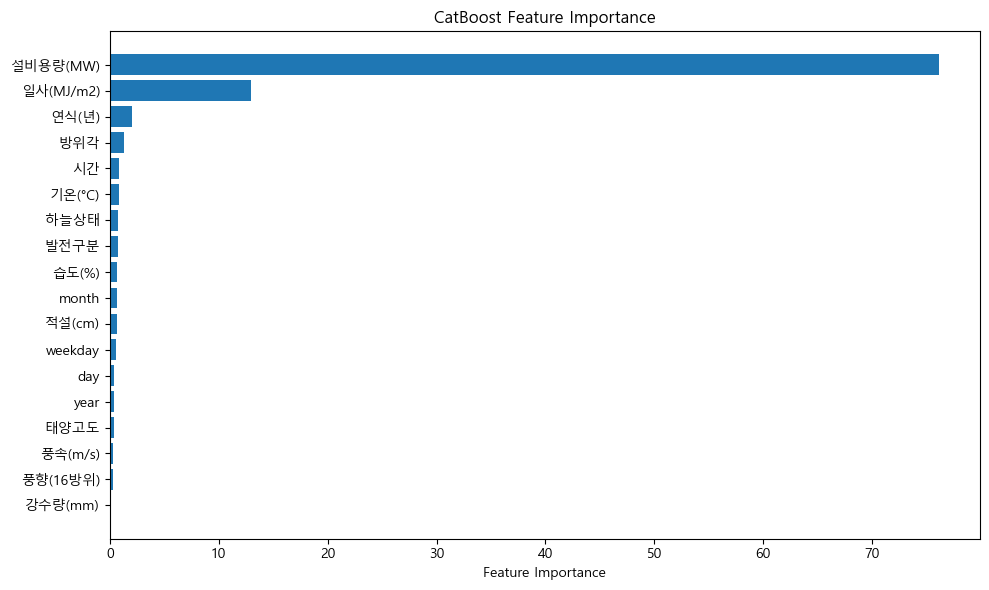

In [84]:
# 한글 폰트 설정 (Windows)
matplotlib.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()  # 가장 중요한 게 위로
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.tight_layout()
plt.show()

## **수용가능한 오차범위인지 확인**

In [89]:
## RMSE / 평균 발전량(비율 기준)
mean_power = y_test.mean()
rmse_ratio = rmse / mean_power
print(f"RMSE 비율: {rmse_ratio:.2%}") 
# 10%이내 : 좋은 성능
# 20%이내 : 실용 가능
# 20% 이상 : 개선 필요

RMSE 비율: 28.54%


## **하이퍼파라미터 튜닝**

In [106]:
# 1. 튜닝할 파라미터 범위 정의
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [3, 5, 7],
    'iterations': [500, 700]
}

# 2. 평가 지표 정의 (R² 기준)
r2_scorer = make_scorer(r2_score)

# 3. RandomizedSearchCV 정의
random_search = RandomizedSearchCV(
    estimator=CatBoostRegressor(verbose=0, random_state=42,early_stopping_rounds=50),
    param_distributions=param_dist,
    scoring=r2_scorer,
    n_iter=8,              # 총 시도할 조합 수
    cv=3,                   # 3-fold 교차검증
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 4. 튜닝 실행 (훈련 데이터 기준)
random_search.fit(X_train, y_train, cat_features=cat_features)

# 5. 최적 결과 출력
print("Best Parameters:", random_search.best_params_)
print("Best R² Score (CV):", random_search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 700, 'depth': 8}
Best R² Score (CV): 0.9712486223184126


## **튜닝된 모델로 평가**

In [108]:
# 최적 모델로 테스트셋 예측
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# 성능 지표 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Tuned RMSE: {rmse:.2f}")
print(f"Tuned R² Score: {r2:.4f}")

# 수용 가능한 오차범위인지 확인
## RMSE / 평균 발전량(비율 기준)
mean_power = y_test.mean()
rmse_ratio = rmse / mean_power
print(f"RMSE 비율: {rmse_ratio:.2%}") 
# 10%이내 : 좋은 성능
# 20%이내 : 실용 가능
# 20% 이상 : 개선 필요

Tuned RMSE: 425.93
Tuned R² Score: 0.9716
RMSE 비율: 27.74%
